In [1]:
# Imports
import random
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

import model

import torch

import keijzer_exogan as ke

# initialize random seeds
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab
# Initialize default seaborn layout
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
sns.set(style='ticks')


"""
Local variables
"""
workers = 0 # Number of workers for dataloader, 0 when to_vram is enabled
batch_size = 1 # using one image ofcourse
image_size = 32
nz = 100 # size of latent vector
n_iters = 25*10**3 # number of iterations to do for inpainting
torch.backends.cudnn.benchmark=True # Uses udnn auto-tuner to find the best algorithm to use for your hardware, speeds up training by almost 50%

lr = 1e-1
lamb1 = 1e3 #1e4
lamb2 = 1 # 1 , total_loss = lamb1*loss_context + lamb2*loss_perceptual

beta1 = 0.5 # Beta1 hyperparam for Adam optimizers
selected_gpus = [3] # Number of GPUs available. Use 0 for CPU mode.

inpaint_n_times = 3000

In [2]:
path = '/datb/16011015/ExoGAN_data/selection//' #notice how you dont put the last folder in here...

# Load all ASPAs

# Load smaller selection of ASPAs

In [3]:
images = np.load(path+'last_chunks_mini_selection.npy')
len(images)

3000

In [4]:
print('Batch size: ', batch_size)


# Number of training epochs

# Learning rate for optimizers
ngpu = len(selected_gpus)
print('Number of GPUs used: ', ngpu)


"""
Load data and prepare DataLoader
"""
shuffle = False

if shuffle:
    np.random.shuffle(images) # shuffles the images

images = images[:1] # 1200 should take ~ 1 hour
#images = images[:int(len(images)*0.005)]
print('Number of images: ', len(images))

Batch size:  1
Number of GPUs used:  1
Number of images:  1


In [5]:
dataset = ke.numpy_dataset(data=images, to_vram=True) # to_vram pins it to all GPU's
#dataset = numpy_dataset(data=images, to_vram=True, transform=transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])) # to_vram pins it to all GPU's

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, pin_memory=False)

"""
Load and setup models
"""
# Initialize cuda
device = torch.device("cuda:"+str(selected_gpus[0]) if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Load models, set to evaluation mode since training is not needed (this also allows batchsize 1 to work with batchnorm2d layers)
netG = model.Generator(ngpu).eval().to(device)
netD = model.Discriminator(ngpu).eval().to(device)

# Apply weights
print('Loading weights...')
try:
    # Load saved weights
    netG.load_state_dict(torch.load('gan_data//weights//netG_state_dict0_v4_test', map_location=device)) #net.module..load_... for parallel model , net.load_... for single gpu model
    netD.load_state_dict(torch.load('gan_data//weights//netD_state_dict0_v4_test', map_location=device))
except:
    print('Could not load saved weights.')
    sys.exit()





"""
Define input training stuff (fancy this up)
"""
G = netG
D = netD
z = torch.randn(1, nz, 1, 1, requires_grad=True, device=device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    G = nn.DataParallel(G, device_ids=selected_gpus, output_device=device)
    D = nn.DataParallel(D, device_ids=selected_gpus, output_device=device)
    #z = nn.DataParallel(z, device_ids=selected_gpus, output_device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999)) # should be sgd
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

print('done')

Loading weights...
done


# Show generated images

(tensor(-1.0266), tensor(1.4084), tensor(0.0802), tensor(0.5576))

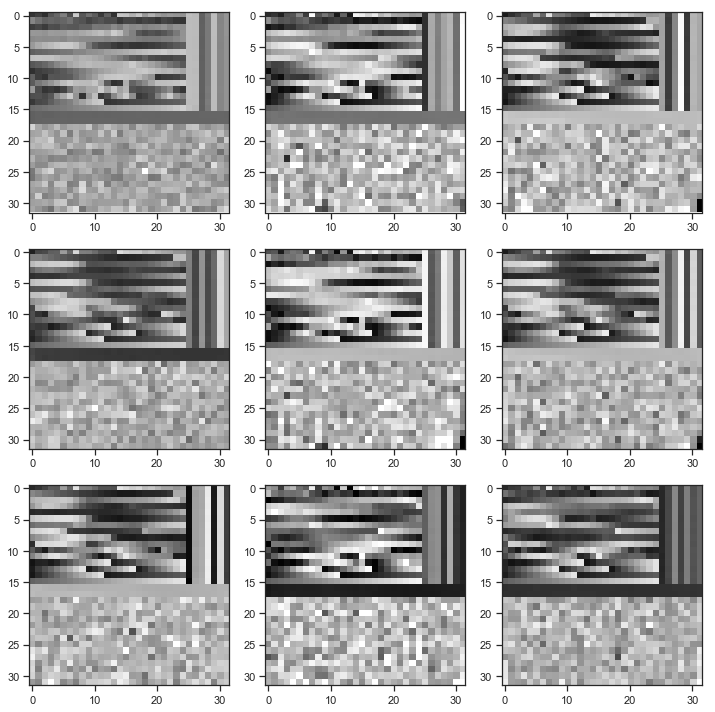

In [6]:
from sklearn.preprocessing import MinMaxScaler

z_tests = [torch.randn(1, nz, 1, 1, device=device) for _ in range(9)]

plt.figure(figsize=(10,10))
for i in range(9):
    img = G(z_tests[i]).detach().cpu()[0, 0, :, :]
    plt.subplot(3,3,i+1)
    #scaler = MinMaxScaler((0, 1.2))
    #img = scaler.fit_transform(img)
    plt.imshow(img, cmap='gray', vmin=-1.2, vmax=1.2)
    #plt.imshow(img, cmap='gray')

plt.tight_layout()

img.min(), img.max(), img.mean(), img.std()

# Show first 9 selected images

(-1.0, 1.0, 0.23500346, 0.54170835)

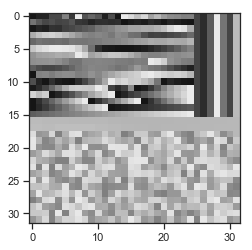

In [7]:
plt.figure(figsize=(10,10))
for i in range(9):
    try:
        img = images[i]
        plt.subplot(3,3,i+1)
        plt.imshow(img[0, :, :], cmap='gray', vmin=-1.2, vmax=1.2)
    except:
        pass

plt.tight_layout()

img.min(), img.max(), img.mean(), img.std()

# Visualizing the weights

Layer: 0 	 n_weights: 512 	 std: 0.0379 	 mean: -0.0002
Layer: 1 	 n_weights: 16384 	 std: 0.4632 	 mean: -0.0102
Layer: 2 	 n_weights: 32768 	 std: 0.4931 	 mean: 0.0444
Layer: 3 	 n_weights: 131072 	 std: 0.6163 	 mean: 0.0343
Layer: 4 	 n_weights: 524288 	 std: 0.1949 	 mean: 0.0029
Layer: 5 	 n_weights: 256 	 std: 0.0080 	 mean: -0.0000


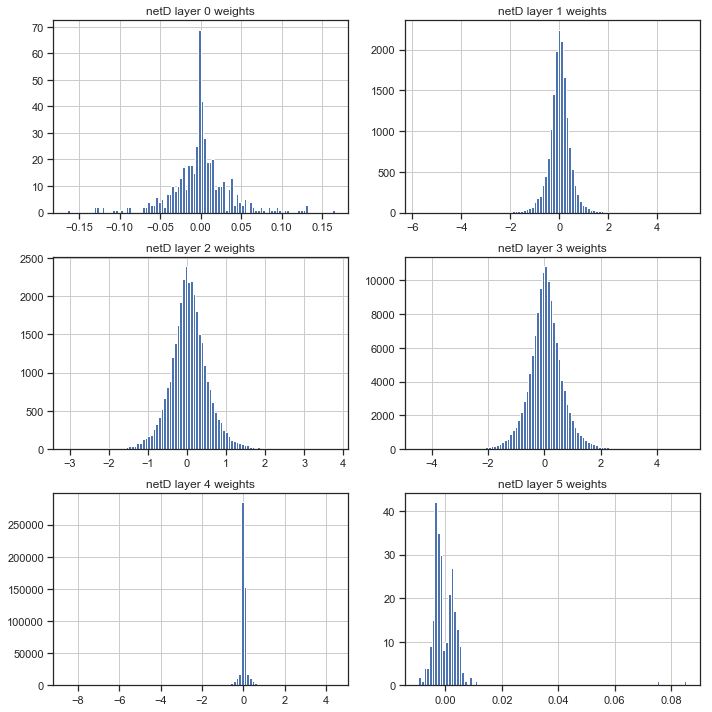

In [8]:
weights = [param.data.cpu().numpy().flatten() for param in netD.parameters()]

plt.figure(figsize=(10,10))
for i,layer_weights in enumerate(weights):
    print('Layer: %s \t n_weights: %s \t std: %.4f \t mean: %.4f' % (i, len(layer_weights), layer_weights.std(), layer_weights.mean()))
    plt.subplot(3,2,i+1)
    plt.title('netD layer %s weights' % i)
    plt.hist(layer_weights, bins=100)
    plt.grid()
    plt.tight_layout()

Layer: 0 	 n_weights: 409600 	 std: 0.1066 	 mean: -0.0001
Layer: 1 	 n_weights: 524288 	 std: 0.1323 	 mean: -0.0095
Layer: 2 	 n_weights: 131072 	 std: 0.1345 	 mean: -0.0083
Layer: 3 	 n_weights: 32768 	 std: 0.1072 	 mean: -0.0118
Layer: 4 	 n_weights: 16384 	 std: 0.0883 	 mean: -0.0018
Layer: 5 	 n_weights: 512 	 std: 0.0232 	 mean: -0.0001


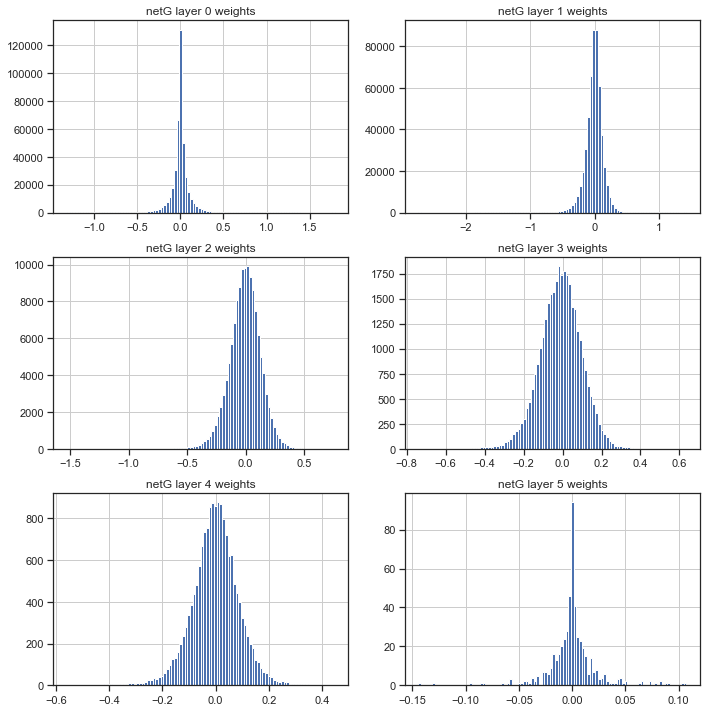

In [9]:
weights = [param.data.cpu().numpy().flatten() for param in netG.parameters()] # where param.data are the weights of the i-th layer

plt.figure(figsize=(10,10))
for i,layer_weights in enumerate(weights):
    print('Layer: %s \t n_weights: %s \t std: %.4f \t mean: %.4f' % (i, len(layer_weights), layer_weights.std(), layer_weights.mean()))
    plt.subplot(3,2,i+1)
    plt.title('netG layer %s weights' % i)
    plt.hist(layer_weights, bins=100)
    plt.grid()
    plt.tight_layout()

# Inpainting
The corrupted image $y$ is mapped to the closest $z$ in the latent representation space, this mapping is denoted as $\hat{z}$.
    
$\hat{z} = \operatorname{arg\,min}_z \{ \mathcal{L}_c(z |y, M) + \mathcal{L}_p (z) \}$

where

$\mathcal{L}_c(z |y, M) = || M \bigodot G(z) - M \bigodot y||_1 = || M \bigodot (G(z)-y) ||_1 $

with $\mathcal{L}_c$ being contextual loss and $M$ being a binary mask with the same size as $y$,

$\mathcal{L}_p (z) = \lambda \operatorname{log}(1-D(G(z)))$

with $\mathcal{L}_p$ being perceptual loss and $D$ being the discriminator.
  
Once $G(\hat{z})$ is generated, the final solution $\hat{x}$ is calculated as

$\hat{x} = \operatorname{arg\, min}_x ||\nabla x - \nabla G(\hat{z}) ||^2_2$  

(substitute $x_i = y_i$ for $M_i = 1$).

-----

$|| ... ||$ is done by `torch.norm()`.  
$... \bigodot ...$ is done by `torch.mul()`.  
-----
TODO: Implement $\hat{x} = \operatorname{arg\, min}_x ||\nabla x - \nabla G(\hat{z}) ||^2_2$    
Currently $\hat{x} = G(\hat{z}) \bigodot (1 -M)+y$

## Create the mask

In [10]:
def create_mask():
    
    mask = np.full([1,1,32,32], 1) # init array with 0.5's
    mask = torch.from_numpy(mask).to(device)
    
    #mask = torch.ones([1, 1, 32, 32]).to(device) # create mask with 1's in the shape of image
    
    #print("mask.shape", mask.shape)

    # use a random 'easy' mask
    
    # set all params to 0
    mask[:, :, :16, 25:] = 0
    
    # set noise to 0
    mask[:, :, 18:, :] = 0
    
    
    """Weighted mask"""
    # Normalization factors
    mask[:, :, 16:18, :] = 6  #6
    
    # Planet mass
    mask[:, :, :16, 25:26] = 0
    
    mask = mask.float() # make sure dtype is float, torch was complaining during inpainting that this is a double
    
    return mask

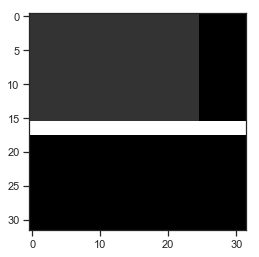

In [11]:
m = create_mask().cpu()[0, 0, :, :]
plt.imshow(m, cmap='gray', vmin=0, vmax=5) 

# Inpaiting functions

## Inpainting loop

In [12]:
# Lists to keep track of progress
real_images = []
masked_images= []
inpainted_images = []
final_inpainted_images = [] # last inpainted image for each input image
n_iteration = []

MSELoss = nn.MSELoss()
L1Loss = nn.L1Loss() # MAE
SmoothL1Loss = nn.SmoothL1Loss()

"""
Inpainting
"""
for i, data in enumerate(dataloader, 0): # batches per epoch
    for j in range(inpaint_n_times):
        real_cpu = data.to(device)
        b_size = real_cpu.size(0) # this is one ofc, it's one image we're trying to inpaint

        #print("data.shape: ", data.shape)
        image = data.to(device) # select the image (Channel, Height, Width), this is the original unmasked input image

        real_images.append(image)
        #print("image.shape: ", image.shape)

        """Mask the image"""
        mask = create_mask()

        masked_image = torch.mul(image, mask).to(device) #image bigodot mask
        masked_images.append(masked_image)
        #print('masked image shape', masked_image.shape)
        #plt.imshow(masked_image.detach().cpu()[0, 0, :, :], cmap='gray') # plot the masked image

        opt = optim.Adam([z], lr=lr)

        # what's v and m?
        v = torch.tensor(0, dtype=torch.float32, device=device)
        m = torch.tensor(0, dtype=torch.float32, device=device)


        """Start the inpainting process"""
        early_stopping_n_iters = 0
        early_stopping_min_loss = 999999 # set to random high number to initialize
        for iteration in range(n_iters):
            t1 = time.time()
            if z.grad is not None:
                z.grad.data.zero_()

            G.zero_grad()
            D.zero_grad()


            image_generated = G(z) # generated image G(z)
            image_generated_masked = torch.mul(image_generated, mask) # G(z) bigodot M
            image_generated_inpainted = torch.mul(image_generated, (1-mask))+masked_image

            if (iteration % 100 == 0):
                inpainted_images.append(image_generated_inpainted)

            #print("image_generated_inpainted.shape : ",image_generated_inpainted.shape)

            t = image_generated_inpainted.detach().cpu()[0, 0, :, :]

            # TODO: why does this already look real?
            #plt.imshow(t, cmap='gray') # plot the masked image 

            """Calculate losses"""
            loss_context = 10*torch.norm(image_generated_masked-masked_image, p=1) #what's p=1?
            #loss_context = lamb1*MSELoss(image_generated_masked,masked_image)
            #loss_context = L1Loss(image_generated_masked, masked_image)*10
            #loss_context = SmoothL1Loss(image_generated_masked, masked_image)*10

            discriminator_output = netD(image_generated_inpainted) - 0.005 # -0.005 offset so loss_perceptual doesn't become 1 when D(G(z)) == 1.000000
            #print("Discriminator output: ", discriminator_output)

            labels = torch.full((b_size,), 1, device=device)
            loss_perceptual = lamb2*torch.log(1-discriminator_output)

            #if loss_perceptual == -np.inf:
            #    #print('loss perceptual == -np.inf()')
            #    loss_perceptual = torch.tensor(-10, dtype=torch.float32, device=device)

            #print(loss_perceptual.data.cpu().numpy().flatten()[0])

            total_loss = loss_context + loss_perceptual
            #total_loss = loss_context + 10*discriminator_output

            # grab the values from losses for printing
            loss_perceptual = loss_perceptual.data.cpu().numpy().flatten()[0]
            #loss_perceptual = 0
            loss_context = loss_context.data.cpu().numpy().flatten()[0]



            total_loss.backward()
            opt.step()

            total_loss = total_loss.data.cpu().numpy().flatten()[0]

            """Early stopping""" # TODO: 
            if iteration > 0:
                delta_loss = early_stopping_min_loss - total_loss
                delta_iters = iteration - iter1

                if (delta_loss < 0.1) or (total_loss > early_stopping_min_loss):
                    early_stopping_n_iters += 1
                else:
                    #print('set to zero')
                    early_stopping_n_iters = 0

                if early_stopping_n_iters > 500:
                    n_iteration.append(iteration)
                    break

            loss1 = total_loss
            iter1 = iteration

            if total_loss < early_stopping_min_loss:
                early_stopping_min_loss = total_loss
                best_inpained_image = image_generated_inpainted.detach().cpu()
                early_stopping_n_iters = 0
                #print('min loss: ', early_stopping_min_loss)

            t2 = time.time()

            """Calculate ETA"""
            t_per_iter = t2 - t1 # time per iteration in seconds

            eta = t_per_iter * (n_iters - iteration) + t_per_iter* (len(images)-i+1) * n_iters # time left to finish epoch/image + time left to finish all epochs/images in SECONDS
            eta_h = (eta/ 60) // 60 # divisor integer
            eta_m = eta % 60 # get remainer

            if (iteration % 50 == 0):
                print("\r image [{}/{}] inpainting [{}/{}] iteration : {:4} , context_loss: {:.3f}, perceptual_loss: {:3f}, total_loss: {:3f}, min L: {:3f}, {:1f}, D(G(z)): {:3f}, ETA: {:.0f}h {:.0f}m".format(i+1, 
                len(images), j, inpaint_n_times, iteration, loss_context,loss_perceptual, total_loss,early_stopping_min_loss, early_stopping_n_iters, discriminator_output.data.cpu().numpy().flatten()[0], eta_h, eta_m),end="")



            """NaN monitor"""
            #if (loss_context or loss_perceptual == np.nan()) and iteration >64:
            #    print(r'='*10 + '     NaN     '+ '='*10)
            #    print(loss_context, loss_percept  ual)
                #break+

        final_inpainted_images.append(best_inpained_image.detach().cpu())

 image [1/1] inpainting [2999/3000] iteration : 1550 , context_loss: 694.328, perceptual_loss: -0.538839, total_loss: 693.788696, min L: 138.570053, 455.000000, D(G(z)): 0.416575, ETA: 0h 16m

In [13]:
i = 1
aspa_real = real_images[i].detach().cpu().numpy()[0, 0, :, :]
aspa_inpainted = final_inpainted_images[i].detach().cpu().numpy()[0, 0, :, :]

In [14]:
ke.decode_params_from_aspa(aspa_real)

{'ch4_mixratio': -23.79337945416555,
 'co2_mixratio': -27.375178609919253,
 'co_mixratio': -9.466183311507404,
 'h2o_mixratio': -20.211580298411846,
 'planet_mass': 2.5306660633087177e+26,
 'planet_radius': 104866500.0,
 'temp_profile': 222.2222089767456}

In [15]:
ke.decode_params_from_aspa(aspa_inpainted)

{'ch4_mixratio': -23.55630230505213,
 'co2_mixratio': -27.927945197548866,
 'co_mixratio': -6.757868075096011,
 'h2o_mixratio': -19.912705024365263,
 'planet_mass': 2.0842149677276612e+26,
 'planet_radius': 107998274.12641048,
 'temp_profile': 495.95141410827637}

# Error on one ASPA

In [16]:
# get the n values of the n inpaintings done on one aspa
reals = [real_images[i].detach().cpu().numpy()[0, 0, :, :] for i in range(inpaint_n_times)]
inpainteds = [final_inpainted_images[i].detach().cpu().numpy()[0, 0, :, :] for i in range(inpaint_n_times)]

reals = [ke.decode_params_from_aspa(aspa_real) for aspa_real in reals]
inpainteds = [ke.decode_params_from_aspa(aspa_inpainted) for aspa_inpainted in inpainteds]

In [17]:
# Initialize ExoGAN params with zero's
inpainted_params = {
    'planet_mass': [],
    'temp_profile': [],
    'ch4_mixratio': [],
    'planet_radius': [],
    'h2o_mixratio': [],
    'co2_mixratio': [],
    'co_mixratio': []
}

In [18]:
# iterate over all params
for i,param in enumerate(inpainted_params):
    # iterate over all inpainted values (of above param)
    for j,inpainted in enumerate(inpainteds):
        y_hat = reals[j][param] # real value
        y = inpainted[param] # inpainted value
        
        percentage_error = ((y - y_hat) / y_hat)*100
        
        inpainted_params[param] += [percentage_error]

In [19]:
df = pd.DataFrame(inpainted_params)
df.describe()

,planet_mass,temp_profile,ch4_mixratio,planet_radius,h2o_mixratio,co2_mixratio,co_mixratio
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,-351.251873,468.979967,-3.721943,1.867152,-0.265224,2.129566,-33.247191
std,30.002346,42.689733,0.270244,0.276060,0.591504,0.237326,1.017620
min,-424.792808,37.612727,-4.953716,1.376534,-3.420404,1.141966,-39.752849
25%,-358.018354,460.928368,-3.829189,1.720845,-0.308974,1.986912,-33.761414
50%,-352.471665,468.508651,-3.701361,1.823150,-0.132688,2.141459,-33.203055
75%,-347.201177,478.490788,-3.590350,1.932009,0.013051,2.287627,-32.662669
max,244.490411,587.257092,-0.260985,4.115837,0.770123,2.909625,-23.754644


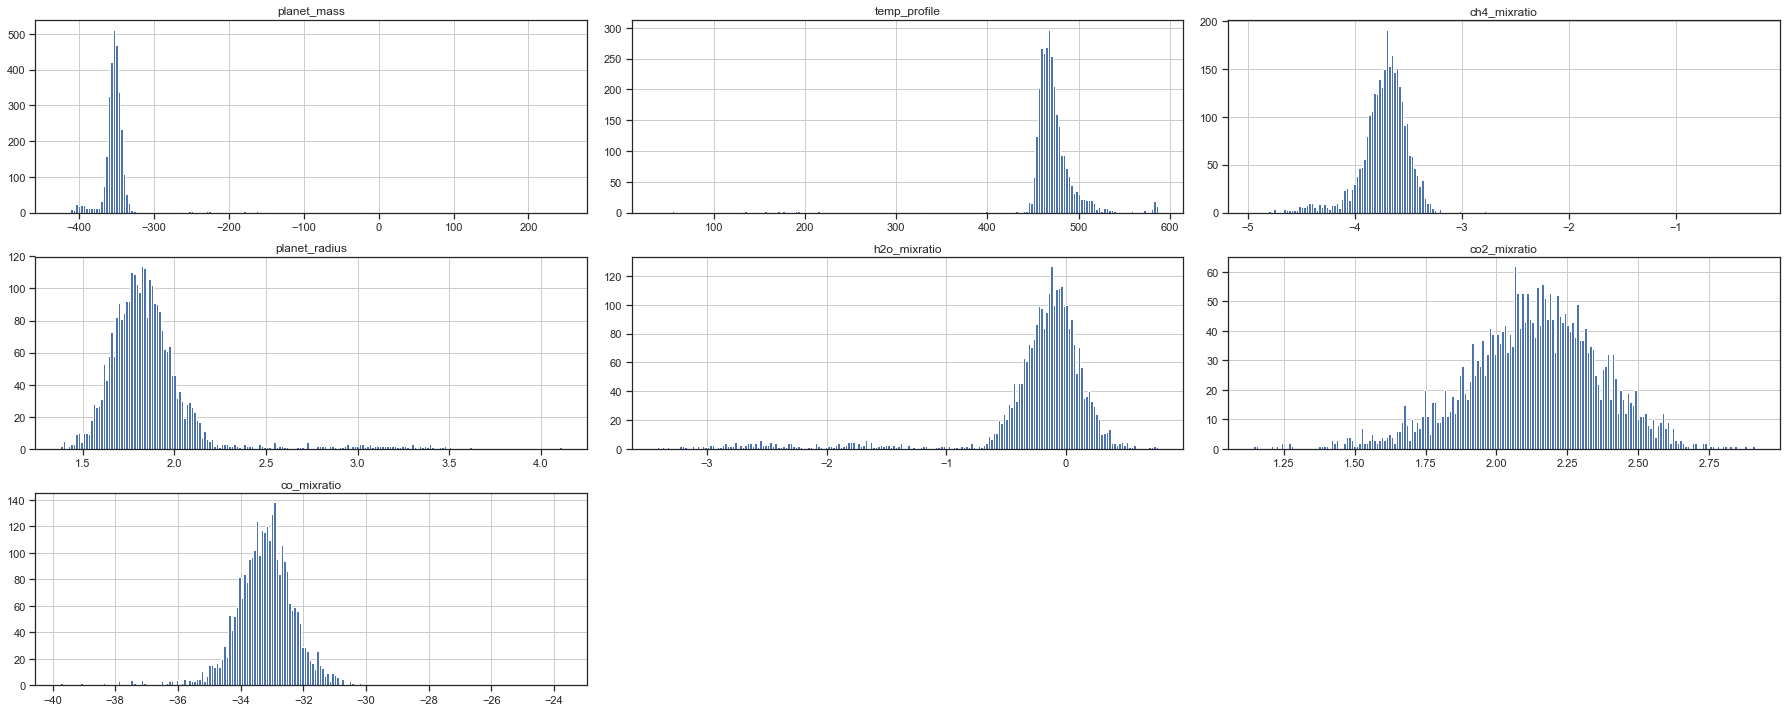

In [22]:
plt.figure(figsize=((25,10)))
for i,param in enumerate(inpainted_params):
    plt.subplot(3,3,i+1)
    plt.title(param)
    plt.hist(df[param], bins=200)
    plt.grid()
    plt.tight_layout()